11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Processing images: 100%|██████████| 10/10 [00:00<00:00, 49.70it/s]


کل بیت‌ها: 62720
تعداد بیت‌های اشتباه: 0
BER = 0.0000


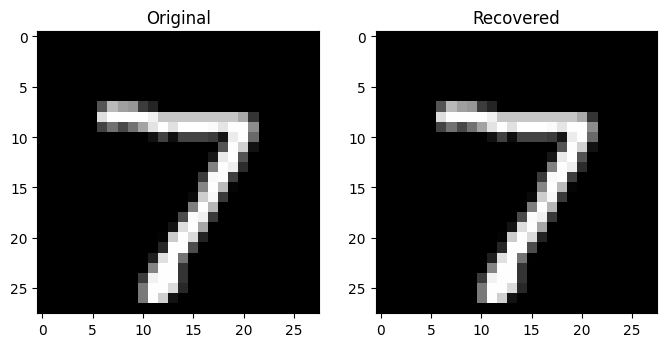

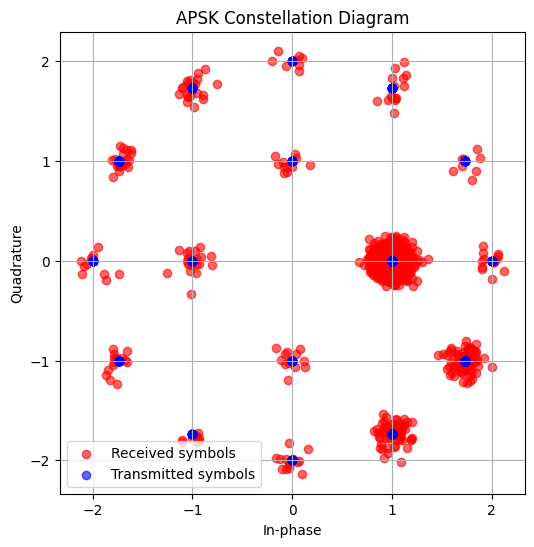

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

# ===============================
# 1. بارگذاری دیتاست MNIST
# ===============================
(x_train, _), (x_test, _) = mnist.load_data()
images = x_test[:10]  # مثال با 10 تصویر
h, w = images.shape[1], images.shape[2]

def image_to_bits(image):
    return np.array([int(b) for pixel in image.flatten() for b in format(pixel, '08b')])

def bits_to_image(bits, shape):
    pixels = [int("".join(map(str, bits[i:i+8])),2) for i in range(0,len(bits),8)]
    return np.array(pixels, dtype=np.uint8).reshape(shape)

# ===============================
# 2. تعریف مدولاسیون APSK
# ===============================
def bits_to_symbols(bits, M=16):
    """
    تبدیل گروه‌های 4 بیتی به نمادهای 16-APSK
    16-APSK: دو حلقه (R1=1, R2=2)
    """
    k = int(np.log2(M))
    symbols = []
    for i in range(0, len(bits), k):
        group = bits[i:i+k]
        if len(group)<k:
            group = np.pad(group, (0,k-len(group)))
        val = int("".join(map(str, group)),2)
        # تعیین حلقه
        if val<4:   # حلقه داخلی
            r = 1
            theta = 2*np.pi*val/4
        else:       # حلقه خارجی
            r = 2
            theta = 2*np.pi*(val-4)/12
        symbols.append(r*np.exp(1j*theta))
    return np.array(symbols)

def symbols_to_bits(symbols, M=16):
    bits = []
    for s in symbols:
        r = np.abs(s)
        theta = np.angle(s) % (2*np.pi)
        # تعیین حلقه
        if r<1.5:
            val = int(round(theta/(2*np.pi/4))) % 4
        else:
            val = int(round(theta/(2*np.pi/12))) % 12 + 4
        b = [int(x) for x in format(val,'04b')]
        bits.extend(b)
    return np.array(bits)

# ===============================
# 3. شبیه‌سازی کانال AWGN
# ===============================
def awgn(symbols, SNR_dB):
    SNR = 10**(SNR_dB/10)
    P = np.mean(np.abs(symbols)**2)
    N0 = P/SNR
    noise = np.sqrt(N0/2)*(np.random.randn(len(symbols))+1j*np.random.randn(len(symbols)))
    return symbols + noise

# ===============================
# 4. پردازش تصاویر
# ===============================
SNR_dB = 20  # میزان SNR
total_bits = 0
bit_errors = 0
recovered_images = []

for img in tqdm(images, desc="Processing images"):
    data = image_to_bits(img)
    total_bits += len(data)

    # مدولاسیون APSK
    symbols = bits_to_symbols(data, M=16)

    # اضافه کردن نویز
    noisy_symbols = awgn(symbols, SNR_dB)

    # دمدولاسیون APSK
    decoded_bits = symbols_to_bits(noisy_symbols, M=16)[:len(data)]

    # محاسبه خطا
    bit_errors += np.sum(data!=decoded_bits)

    # بازگرداندن تصویر
    recovered_images.append(bits_to_image(decoded_bits, (h,w)))

BER = bit_errors/total_bits
print(f"کل بیت‌ها: {total_bits}")
print(f"تعداد بیت‌های اشتباه: {bit_errors}")
print(f"BER = {BER:.4f}")

# ===============================
# 5. نمایش نمونه تصویر و constellation
# ===============================
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(images[0], cmap='gray')
plt.subplot(1,2,2); plt.title("Recovered"); plt.imshow(recovered_images[0], cmap='gray')
plt.show()

# رسم constellation
plt.figure(figsize=(6,6))
plt.scatter(np.real(noisy_symbols), np.imag(noisy_symbols), color='red', alpha=0.6, label='Received symbols')
plt.scatter(np.real(symbols), np.imag(symbols), color='blue', alpha=0.6, label='Transmitted symbols')
plt.title("APSK Constellation Diagram")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()
